In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import mannwhitneyu,ranksums,chi2_contingency
from Bio import SeqIO
from Bio.Seq import Seq
from collections import defaultdict
import re
from collections import Counter

### file inputs

In [9]:
fg_editing_site_cds = pd.read_csv('../identified_editing_sites/AtoI_in_cds_annotated/fg_editing_AG_in_cds_anno.csv')
nc_editing_site_cds = pd.read_csv('../identified_editing_sites/AtoI_in_cds_annotated/nc_editing_AG_in_cds_anno.csv')
nt_editing_site_cds = pd.read_csv('../identified_editing_sites/AtoI_in_cds_annotated/nt_editing_AG_in_cds_anno.csv')

fg_genomic = '../genomic_data/fgraminearum/GCA_900044135.1_GZPH1RResV1_genomic.fna'
nc_genomic = '../genomic_data/ncrassa/GCF_000182925.2_NC12_genomic.fna'
nt_genomic = '../genomic_data/ntetrasperma/GCF_000213175.1_v2.0_genomic.fna'

fg_gff = '../genomic_data/fgraminearum/GCA_900044135.1_GZPH1RResV1_genomic.gff'
nc_gff = '../genomic_data/ncrassa/GCF_000182925.2_NC12_genomic.gff'
nt_gff = '../genomic_data/ntetrasperma/GCF_000213175.1_v2.0_genomic.gff'

fg_canonical_cds = '../genomic_data/fgraminearum/fg_canonical_cds.fasta'
nc_canonical_cds = '../genomic_data/ncrassa/nc_canonical_cds.fasta'
nt_canonical_cds = '../genomic_data/ntetrasperma/nt_canonical_cds.fasta'

nc_psc = pd.read_csv('../stop_codon_positions/nc_psc_PNAS.txt',header=None)
fg_psc = pd.read_csv('../stop_codon_positions/fg_psc_id_conversion.txt',sep='\t')
nt_psc = pd.read_csv('../stop_codon_positions/nt_psc_locus_tag.txt',sep='\t')
nt_psc = nt_psc[~nt_psc['locus_tag'].isna()]

fg_sex_list = pd.read_csv('../expr_and_motif_avoid/gene_list/fg_S_genes.txt',header=None)
fg_not_sex_list = pd.read_csv('../expr_and_motif_avoid/gene_list/fg_NotS_genes.txt',header=None)

nc_sex_list = pd.read_csv('../expr_and_motif_avoid/gene_list/nc_S_genes.txt',header=None)
nc_not_sex_list = pd.read_csv('../expr_and_motif_avoid/gene_list/nc_NotS_genes.txt',header=None)

nt_sex_list = pd.read_csv('../expr_and_motif_avoid/gene_list/nt_S_genes.txt',header=None)
nt_not_sex_list = pd.read_csv('../expr_and_motif_avoid/gene_list/nt_NotS_genes.txt',header=None)

### removing genes with premature stop editing; separate into expressed during sex and those not expressed during sex

In [10]:
def read_fasta(file_path):
    sequences = {}
    with open(file_path, "r") as f:
        seq_id, seq_lines = None, []
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq_id is not None:
                    sequences[seq_id] = "".join(seq_lines)
                seq_id, seq_lines = line[1:], []
            else:
                seq_lines.append(line)
        if seq_id is not None:
            sequences[seq_id] = "".join(seq_lines)
    return sequences

def gid(h):
    return h.split()[0].split("|")[-1]

def extract_cds(cds_fasta, gene_df):
    cds = read_fasta(cds_fasta)
    idx = {gid(h): seq for h, seq in cds.items()}
    ids = gene_df.iloc[:, 0].astype(str).str.strip()
    return {g: idx[g] for g in ids if g in idx}

FG_PSC_EXCLUDE = set(
    fg_psc["RR1.41"]
    .dropna().astype(str).str.split(",").explode().str.strip()
    .replace("", np.nan).dropna().unique()
)

NC_PSC_EXCLUDE = set(
    nc_psc.iloc[:, 0]
    .dropna().astype(str).str.strip()
    .replace("", np.nan).dropna().unique()
)

NT_PSC_EXCLUDE = set(
    nt_psc["locus_tag"]
    .dropna().astype(str).str.strip()
    .replace("", np.nan).dropna().unique()
)

fg_sex_list = fg_sex_list.loc[~fg_sex_list.iloc[:,0].astype(str).str.strip().isin(FG_PSC_EXCLUDE)].reset_index(drop=True)
fg_not_sex_list = fg_not_sex_list.loc[~fg_not_sex_list.iloc[:,0].astype(str).str.strip().isin(FG_PSC_EXCLUDE)].reset_index(drop=True)

nc_sex_list = nc_sex_list.loc[~nc_sex_list.iloc[:,0].astype(str).str.strip().isin(NC_PSC_EXCLUDE)].reset_index(drop=True)
nc_not_sex_list = nc_not_sex_list.loc[~nc_not_sex_list.iloc[:,0].astype(str).str.strip().isin(NC_PSC_EXCLUDE)].reset_index(drop=True)

nt_sex_list = nt_sex_list.loc[~nt_sex_list.iloc[:,0].astype(str).str.strip().isin(NT_PSC_EXCLUDE)].reset_index(drop=True)
nt_not_sex_list = nt_not_sex_list.loc[~nt_not_sex_list.iloc[:,0].astype(str).str.strip().isin(NT_PSC_EXCLUDE)].reset_index(drop=True)

fg_not_sex_cds = extract_cds(fg_canonical_cds, fg_not_sex_list)
fg_sex_cds     = extract_cds(fg_canonical_cds, fg_sex_list)

nc_not_sex_cds = extract_cds(nc_canonical_cds, nc_not_sex_list)
nc_sex_cds     = extract_cds(nc_canonical_cds, nc_sex_list)

nt_not_sex_cds = extract_cds(nt_canonical_cds, nt_not_sex_list)
nt_sex_cds     = extract_cds(nt_canonical_cds, nt_sex_list)

fg_not_sex_genes_list = list(fg_not_sex_cds.keys())
nc_not_sex_genes_list = list(nc_not_sex_cds.keys())
nt_not_sex_genes_list = list(nt_not_sex_cds.keys())

fg_editing_site_cds = fg_editing_site_cds.loc[
    ~fg_editing_site_cds["GeneID(Symbol)"].astype(str).str.strip().isin(FG_PSC_EXCLUDE)
].copy()

nc_editing_site_cds = nc_editing_site_cds.loc[
    ~nc_editing_site_cds["GeneID(Symbol)"].astype(str).str.strip().isin(NC_PSC_EXCLUDE)
].copy()

nt_editing_site_cds = nt_editing_site_cds.loc[
    ~nt_editing_site_cds["GeneID(Symbol)"].astype(str).str.strip().isin(NT_PSC_EXCLUDE)
].copy()

fg_editing_site_nonsyn = fg_editing_site_cds[fg_editing_site_cds["Effect"]=="non-syn"].copy()
fg_editing_site_syn    = fg_editing_site_cds[(fg_editing_site_cds["Effect"]=="syn") & (fg_editing_site_cds["edit_codon_pos"]!=2)].copy()

nc_editing_site_nonsyn = nc_editing_site_cds[nc_editing_site_cds["Effect"]=="non-syn"].copy()
nc_editing_site_syn    = nc_editing_site_cds[(nc_editing_site_cds["Effect"]=="syn") & (nc_editing_site_cds["edit_codon_pos"]!=2)].copy()

nt_editing_site_nonsyn = nt_editing_site_cds[nt_editing_site_cds["Effect"]=="non-syn"].copy()
nt_editing_site_syn    = nt_editing_site_cds[(nt_editing_site_cds["Effect"]=="syn") & (nt_editing_site_cds["edit_codon_pos"]!=2)].copy()

fg_nonsyn_sex = fg_editing_site_nonsyn[fg_editing_site_nonsyn["GeneID(Symbol)"].astype(str).str.strip().isin(set(fg_sex_list.iloc[:,0].astype(str).str.strip()))].copy()
fg_syn_sex    = fg_editing_site_syn[fg_editing_site_syn["GeneID(Symbol)"].astype(str).str.strip().isin(set(fg_sex_list.iloc[:,0].astype(str).str.strip()))].copy()

fg_nonsyn_not_sex = fg_editing_site_nonsyn[fg_editing_site_nonsyn["GeneID(Symbol)"].astype(str).str.strip().isin(set(fg_not_sex_list.iloc[:,0].astype(str).str.strip()))].copy()
fg_syn_not_sex    = fg_editing_site_syn[fg_editing_site_syn["GeneID(Symbol)"].astype(str).str.strip().isin(set(fg_not_sex_list.iloc[:,0].astype(str).str.strip()))].copy()

nc_nonsyn_sex = nc_editing_site_nonsyn[nc_editing_site_nonsyn["GeneID(Symbol)"].astype(str).str.strip().isin(set(nc_sex_list.iloc[:,0].astype(str).str.strip()))].copy()
nc_syn_sex    = nc_editing_site_syn[nc_editing_site_syn["GeneID(Symbol)"].astype(str).str.strip().isin(set(nc_sex_list.iloc[:,0].astype(str).str.strip()))].copy()

nc_nonsyn_not_sex = nc_editing_site_nonsyn[nc_editing_site_nonsyn["GeneID(Symbol)"].astype(str).str.strip().isin(set(nc_not_sex_list.iloc[:,0].astype(str).str.strip()))].copy()
nc_syn_not_sex    = nc_editing_site_syn[nc_editing_site_syn["GeneID(Symbol)"].astype(str).str.strip().isin(set(nc_not_sex_list.iloc[:,0].astype(str).str.strip()))].copy()

nt_nonsyn_sex = nt_editing_site_nonsyn[nt_editing_site_nonsyn["GeneID(Symbol)"].astype(str).str.strip().isin(set(nt_sex_list.iloc[:,0].astype(str).str.strip()))].copy()
nt_syn_sex    = nt_editing_site_syn[nt_editing_site_syn["GeneID(Symbol)"].astype(str).str.strip().isin(set(nt_sex_list.iloc[:,0].astype(str).str.strip()))].copy()

nt_nonsyn_not_sex = nt_editing_site_nonsyn[nt_editing_site_nonsyn["GeneID(Symbol)"].astype(str).str.strip().isin(set(nt_not_sex_list.iloc[:,0].astype(str).str.strip()))].copy()
nt_syn_not_sex    = nt_editing_site_syn[nt_editing_site_syn["GeneID(Symbol)"].astype(str).str.strip().isin(set(nt_not_sex_list.iloc[:,0].astype(str).str.strip()))].copy()

In [11]:
print(len(fg_not_sex_cds))
print(len(fg_sex_cds))
print(len(nc_not_sex_cds))
print(len(nc_sex_cds))
print(len(nt_not_sex_cds))
print(len(nt_sex_cds))

2213
11853
593
9079
1446
8886


In [12]:
def read_fasta(file_path):
    sequences = {}
    with open(file_path, "r") as f:
        seq_id, seq_lines = None, []
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq_id is not None:
                    sequences[seq_id] = "".join(seq_lines)
                seq_id, seq_lines = line[1:], []
            else:
                seq_lines.append(line)
        if seq_id is not None:
            sequences[seq_id] = "".join(seq_lines)
    return sequences

def gid(h):
    return h.split()[0].split("|")[-1]

def extract_cds(cds_fasta, gene_df):
    cds = read_fasta(cds_fasta)
    idx = {gid(h): seq for h, seq in cds.items()}
    ids = gene_df.iloc[:, 0].astype(str).str.strip()
    return {g: idx[g] for g in ids if g in idx}

def _as_clean_gene_set(x):
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    if isinstance(x, pd.Series):
        vals = x.astype(str)
    else:
        vals = pd.Series(list(x)).astype(str)
    vals = vals.str.strip()
    vals = vals[vals.ne("") & vals.ne("nan") & vals.notna()]
    return set(vals)

def _strip_df_cols(df):
    df.columns = df.columns.str.strip()
    return df

In [13]:
GENETIC_CODE = {
    'TTT':'F','TTC':'F','TTA':'L','TTG':'L','TCT':'S','TCC':'S','TCA':'S','TCG':'S',
    'TAT':'Y','TAC':'Y','TAA':'*','TAG':'*','TGT':'C','TGC':'C','TGA':'*','TGG':'W',
    'CTT':'L','CTC':'L','CTA':'L','CTG':'L','CCT':'P','CCC':'P','CCA':'P','CCG':'P',
    'CAT':'H','CAC':'H','CAA':'Q','CAG':'Q','CGT':'R','CGC':'R','CGA':'R','CGG':'R',
    'ATT':'I','ATC':'I','ATA':'I','ATG':'M','ACT':'T','ACC':'T','ACA':'T','ACG':'T',
    'AAT':'N','AAC':'N','AAA':'K','AAG':'K','AGT':'S','AGC':'S','AGA':'R','AGG':'R',
    'GTT':'V','GTC':'V','GTA':'V','GTG':'V','GCT':'A','GCC':'A','GCA':'A','GCG':'A',
    'GAT':'D','GAC':'D','GAA':'E','GAG':'E','GGT':'G','GGC':'G','GGA':'G','GGG':'G'
}

def aa_of(codon: str) -> str:
    return GENETIC_CODE.get(codon, 'X')

def count_potential_A_to_G(cds_records):
    if isinstance(cds_records, dict):
        seq_iter = cds_records.values()
    else:
        seq_iter = cds_records

    syn_total = 0
    nonsyn_total = 0

    motifs = ['AA','TA','CA','GA']
    motif_counts    = {m: 0 for m in motifs}
    syn_by_motif    = {m: 0 for m in motifs}
    nonsyn_by_motif = {m: 0 for m in motifs}

    for seq in seq_iter:
        if not seq:
            continue
        s = str(seq).upper().replace('U', 'T')
        L = len(s)
        if L % 3 != 0 or L < 9:
            continue

        n_codons = L // 3
        for codon_idx in range(1, n_codons - 1):
            codon_start = codon_idx * 3
            codon = s[codon_start:codon_start+3]
            orig_aa = aa_of(codon)
            if orig_aa in ('*', 'X'):
                continue

            for pos_in_codon in (0, 1, 2):
                i = codon_start + pos_in_codon
                if s[i] != 'A':
                    continue

                prev = s[i-1] if i > 0 else 'N'
                if prev not in 'ACGT':
                    continue

                mut = list(codon)
                mut[pos_in_codon] = 'G'
                mut_codon = ''.join(mut)
                mut_aa = aa_of(mut_codon)
                if mut_aa == 'X':
                    continue

                motif = prev + 'A'
                if motif in motif_counts:
                    motif_counts[motif] += 1

                if mut_aa == orig_aa:
                    syn_total += 1
                    if motif in syn_by_motif:
                        syn_by_motif[motif] += 1
                else:
                    nonsyn_total += 1
                    if motif in nonsyn_by_motif:
                        nonsyn_by_motif[motif] += 1

    return {
        'syn_total': syn_total,
        'nonsyn_total': nonsyn_total,
        'motif_counts': motif_counts,
        'syn_by_motif': syn_by_motif,
        'nonsyn_by_motif': nonsyn_by_motif,
    }

fg_cds = read_fasta(fg_canonical_cds)
fg_cds = {gid(h): seq for h, seq in fg_cds.items()}
fg_cds = {g: s for g, s in fg_cds.items() if g not in FG_PSC_EXCLUDE}

nc_cds = read_fasta(nc_canonical_cds)
nc_cds = {gid(h): seq for h, seq in nc_cds.items()}
nc_cds = {g: s for g, s in nc_cds.items() if g not in NC_PSC_EXCLUDE}

nt_cds = read_fasta(nt_canonical_cds)
nt_cds = {gid(h): seq for h, seq in nt_cds.items()}
nt_cds = {g: s for g, s in nt_cds.items() if g not in NT_PSC_EXCLUDE}

fg_results = count_potential_A_to_G(fg_cds)
nc_results = count_potential_A_to_G(nc_cds)
nt_results = count_potential_A_to_G(nt_cds)

print("FG:", fg_results)
print("NC:", nc_results)
print("NT:", nt_results)

FG: {'syn_total': 1162040, 'nonsyn_total': 3638696, 'motif_counts': {'AA': 1243641, 'TA': 648762, 'CA': 1467929, 'GA': 1440404}, 'syn_by_motif': {'AA': 376133, 'TA': 126617, 'CA': 405414, 'GA': 253876}, 'nonsyn_by_motif': {'AA': 867508, 'TA': 522145, 'CA': 1062515, 'GA': 1186528}}
NC: {'syn_total': 700003, 'nonsyn_total': 2785640, 'motif_counts': {'AA': 869602, 'TA': 394658, 'CA': 1114774, 'GA': 1106609}, 'syn_by_motif': {'AA': 257101, 'TA': 72395, 'CA': 227664, 'GA': 142843}, 'nonsyn_by_motif': {'AA': 612501, 'TA': 322263, 'CA': 887110, 'GA': 963766}}
NT: {'syn_total': 682795, 'nonsyn_total': 2718729, 'motif_counts': {'AA': 848299, 'TA': 391088, 'CA': 1082322, 'GA': 1079815}, 'syn_by_motif': {'AA': 249888, 'TA': 71808, 'CA': 220869, 'GA': 140230}, 'nonsyn_by_motif': {'AA': 598411, 'TA': 319280, 'CA': 861453, 'GA': 939585}}


In [14]:
def plot_syn_nonsyn_boxplot(species_dict, ylabel="Editing Level (%)", title=None, save_path=None):
    box_colors = ['grey', 'black']
    edit_types = ['Synonymous ($\\it{L}_{\\mathrm{S}}$)', 'Nonsynonymous ($\\it{L}_{\\mathrm{N}}$)']  # kept (not used below)

    species_labels = {
        'fg': r"$\it{F.\ graminearum}$",
        'nc': r"$\it{N.\ crassa}$",
        'nt': r"$\it{N.\ tetrasperma}$"
    }
    species_order = list(species_dict.keys())

    all_data = []
    for sp in species_order:
        s_edit = species_dict[sp].get("syn", pd.Series(dtype=float)).dropna()
        n_edit = species_dict[sp].get("nonsyn", pd.Series(dtype=float)).dropna()
        all_data.append([s_edit, n_edit])

    fig, ax = plt.subplots(figsize=(13, 6))
    positions, box_data, colors, xticks, xtick_labels = [], [], [], [], []

    spacing, width = 3, 0.6

    for i, (sp, (s, n)) in enumerate(zip(species_order, all_data)):
        base = i * spacing
        box_data.extend([s, n])
        positions.extend([base, base + 1])
        colors.extend(box_colors)
        xticks.append(base + 0.5)
        xtick_labels.append(species_labels.get(sp, sp))

    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=width,
        patch_artist=True,
        medianprops=dict(color='white', linewidth=1.5),
        showfliers=False
    )

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_linewidth(0)

    ax.set_ylabel(ylabel, fontsize=22)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, fontsize=22)
    ax.tick_params(axis='y', labelsize=22)

    ax.set_ylim(-2, 70)
    ymin, ytop = ax.get_ylim()
    yrange = ytop - ymin

    if title:
        ax.set_title(title, fontsize=22)

    def get_stars(pval):
        if pval < 0.0001:
            return "****"
        elif pval < 0.001:
            return "***"
        elif pval < 0.01:
            return "**"
        elif pval < 0.05:
            return "*"
        else:
            return "ns"

    for i, (s, n) in enumerate(all_data):
        base = i * spacing
        if len(s) == 0 or len(n) == 0:
            continue

        y_max = np.nanmax([s.max(), n.max()])

        bar_gap = 0.13 * yrange
        text_gap = 0.12 * yrange

        line_y = y_max + bar_gap
        text_y = line_y + text_gap

        line_y = min(line_y, ytop - 0.10 * yrange)
        text_y = min(text_y, ytop - 0.04 * yrange)

        try:
            pval = mannwhitneyu(n, s, alternative='two-sided').pvalue
            stars = get_stars(pval)

            ax.plot([base, base + 1], [line_y, line_y], color='black', linewidth=1)
            ax.text(base + 0.5, text_y, stars, ha='center', fontsize=22)
        except Exception:
            pass

    sns.despine()
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [15]:
MOTIFS = ("TA", "AA", "CA", "GA")
BASE_TO_MOTIF = {"T":"TA", "A":"AA", "C":"CA", "G":"GA"}

def motif_edit_probs(edited_by_motif: dict, motif_counts: dict, motifs=MOTIFS):
    probs = {}
    for m in motifs:
        denom = motif_counts.get(m, 0)
        probs[m] = (edited_by_motif.get(m, 0) / denom) if denom else 0.0
    return probs

def expected_NS_from_res(res: dict, probs: dict, motifs=MOTIFS):
    N = sum(res["nonsyn_by_motif"].get(m, 0) * probs.get(m, 0.0) for m in motifs)
    S = sum(res["syn_by_motif"].get(m, 0) * probs.get(m, 0.0) for m in motifs)
    return N, S

def Fn_Fs(obs_n, obs_s, total_A, N, S):
    denom = N + S
    if denom == 0:
        return np.nan, np.nan
    Fn = obs_n / (total_A * (N / denom)) if N > 0 else np.nan
    Fs = obs_s / (total_A * (S / denom)) if S > 0 else np.nan
    return Fn, Fs

def chi2_Fn_vs_Fs(obs_n, obs_s, total_A, N, S):
    denom = N + S
    if denom == 0:
        return np.nan, np.nan, np.nan, None
    exp_n = total_A * (N / denom)
    exp_s = total_A * (S / denom)
    table = np.array([[obs_n, exp_n - obs_n],
                      [obs_s, exp_s - obs_s]], dtype=float)
    chi2, p, dof, expected = chi2_contingency(table)
    return chi2, p, dof, expected

def edited_by_motif_from_dfs(nonsyn_df_sub, syn_df_sub, motifs=MOTIFS):
    x = pd.concat([nonsyn_df_sub["base_before_edit"], syn_df_sub["base_before_edit"]], ignore_index=True)
    x = x.astype(str).str.strip().str.upper().str[0]
    x = x[x.isin(list("ATCG"))].map(BASE_TO_MOTIF)
    vc = x.value_counts().to_dict()
    return {m: int(vc.get(m, 0)) for m in motifs}

def run_condition(res, edited_by_motif, obs_n, obs_s, motifs=MOTIFS):
    probs = motif_edit_probs(edited_by_motif, res["motif_counts"], motifs=motifs)
    N, S = expected_NS_from_res(res, probs, motifs=motifs)
    total_A = res["syn_total"] + res["nonsyn_total"]
    Fn, Fs = Fn_Fs(obs_n, obs_s, total_A, N, S)
    chi2, p, dof, expected = chi2_Fn_vs_Fs(obs_n, obs_s, total_A, N, S)
    return {"total_A": total_A, "obs_n": obs_n, "obs_s": obs_s, "N": N, "S": S, "Fn": Fn, "Fs": Fs, "p": p}

fg_sex_res     = count_potential_A_to_G(fg_sex_cds)
fg_not_sex_res = count_potential_A_to_G(fg_not_sex_cds)
nc_sex_res     = count_potential_A_to_G(nc_sex_cds)
nc_not_sex_res = count_potential_A_to_G(nc_not_sex_cds)
nt_sex_res     = count_potential_A_to_G(nt_sex_cds)
nt_not_sex_res = count_potential_A_to_G(nt_not_sex_cds)

fg_sex_genes = set(fg_sex_list.iloc[:,0].astype(str).str.strip())
fg_not_genes = set(fg_not_sex_list.iloc[:,0].astype(str).str.strip())

nc_sex_genes = set(nc_sex_list.iloc[:,0].astype(str).str.strip())
nc_not_genes = set(nc_not_sex_list.iloc[:,0].astype(str).str.strip())

nt_sex_genes = set(nt_sex_list.iloc[:,0].astype(str).str.strip())
nt_not_genes = set(nt_not_sex_list.iloc[:,0].astype(str).str.strip())

specs = {
    ("FG", "sex"):     dict(res=fg_sex_res,     nonsyn_df=fg_editing_site_nonsyn, syn_df=fg_editing_site_syn, genes=fg_sex_genes),
    ("FG", "not_sex"): dict(res=fg_not_sex_res, nonsyn_df=fg_editing_site_nonsyn, syn_df=fg_editing_site_syn, genes=fg_not_genes),
    ("NC", "sex"):     dict(res=nc_sex_res,     nonsyn_df=nc_editing_site_nonsyn, syn_df=nc_editing_site_syn, genes=nc_sex_genes),
    ("NC", "not_sex"): dict(res=nc_not_sex_res, nonsyn_df=nc_editing_site_nonsyn, syn_df=nc_editing_site_syn, genes=nc_not_genes),
    ("NT", "sex"):     dict(res=nt_sex_res,     nonsyn_df=nt_editing_site_nonsyn, syn_df=nt_editing_site_syn, genes=nt_sex_genes),
    ("NT", "not_sex"): dict(res=nt_not_sex_res, nonsyn_df=nt_editing_site_nonsyn, syn_df=nt_editing_site_syn, genes=nt_not_genes),
}

rows = []
for (sp, cond), d in specs.items():
    nonsyn_sub = d["nonsyn_df"][d["nonsyn_df"]["GeneID(Symbol)"].astype(str).str.strip().isin(d["genes"])]
    syn_sub    = d["syn_df"]   [d["syn_df"]   ["GeneID(Symbol)"].astype(str).str.strip().isin(d["genes"])]

    obs_n, obs_s = int(len(nonsyn_sub)), int(len(syn_sub))
    edited = edited_by_motif_from_dfs(nonsyn_sub, syn_sub)

    out = run_condition(d["res"], edited, obs_n, obs_s)
    rows.append({"species": sp, "condition": cond, "total_A": out["total_A"],
                 "n": out["obs_n"], "s": out["obs_s"], "N": out["N"], "S": out["S"],
                 "Fn": out["Fn"], "Fs": out["Fs"], "p": out["p"]})

results_df = pd.DataFrame(rows).sort_values(["species", "condition"]).reset_index(drop=True)
results_df

,species,condition,total_A,n,s,N,S,Fn,Fs,p
0,FG,not_sex,520652,17,6,17.880471,5.119529,0.000042,0.000052,8.487470e-01
1,FG,sex,4279569,25891,6255,25338.468910,6786.531090,0.007670,0.006919,2.072192e-13
2,NC,not_sex,106607,3,1,3.167862,0.832138,0.000036,0.000045,1.000000e+00
3,NC,sex,3368643,23555,4908,23045.192450,5391.807550,0.008628,0.007684,1.224354e-13
4,NT,not_sex,195580,15,4,14.678296,4.321704,0.000099,0.000090,1.000000e+00
5,NT,sex,3205905,17608,3486,17100.018037,3976.981963,0.006770,0.005763,2.869532e-18


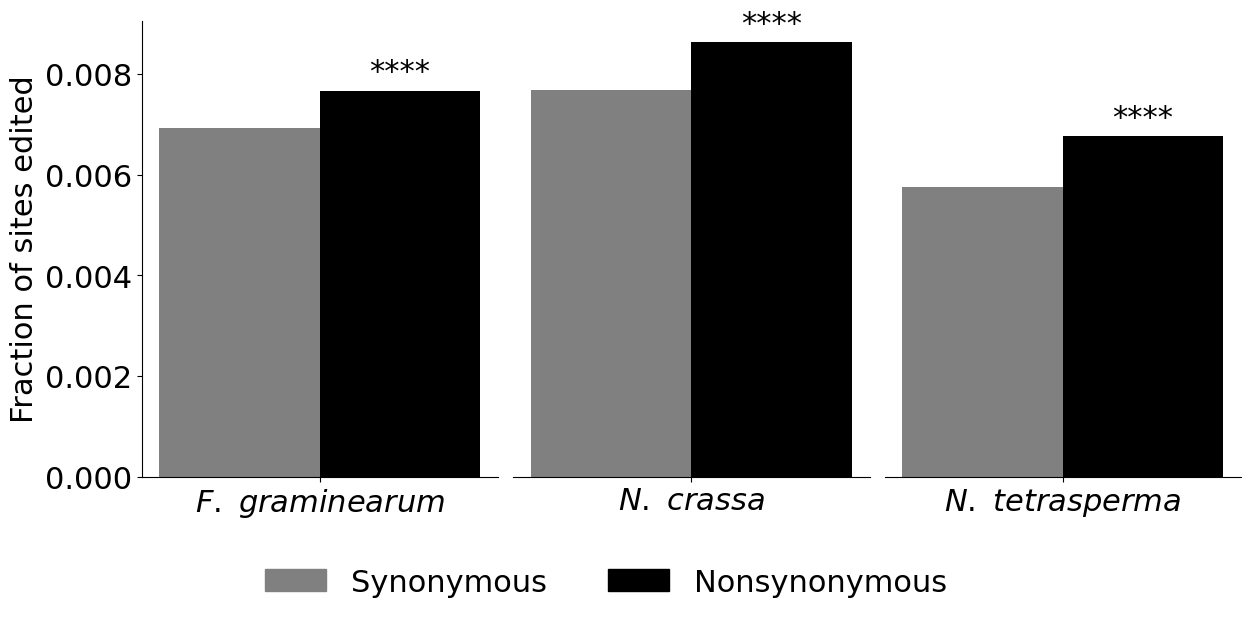

(<Figure size 1300x600 with 3 Axes>,
 array([<Axes: ylabel='Fraction of sites edited'>, <Axes: >, <Axes: >],
       dtype=object))

In [16]:
def p_to_sig(pval):
    if pval < 1e-4:
        return "****"
    elif pval < 1e-3:
        return "***"
    elif pval < 1e-2:
        return "**"
    elif pval < 5e-2:
        return "*"
    else:
        return "ns"

def pretty_species(sp):
    return {
        "FG": r"$\it{F.\ graminearum}$",
        "NC": r"$\it{N.\ crassa}$",
        "NT": r"$\it{N.\ tetrasperma}$",
    }.get(sp, sp)

def plot_fnfs_from_results(results_df,
                                      out_pdf=None,
                                      sp_order=("FG", "NC", "NT"),
                                      bar_width=0.45,
                                      top_pad_frac=0.01,   
                                      legend_y=-0.10,
                                      figsize=(13, 6),
                                      stars_fontsize=22,
                                      label_fontsize=22,
                                      tick_fontsize=22):
    
    # use genes that are only expressed during sex
    df = results_df.copy()
    df = df[df["condition"] == "sex"].copy()
    df["species"] = pd.Categorical(df["species"], categories=list(sp_order), ordered=True)
    df = df.sort_values("species").reset_index(drop=True)

    species_meta = [
        ("FG", r"$\it{F.\ graminearum}$"),
        ("NC", r"$\it{N.\ crassa}$"),
        ("NT", r"$\it{N.\ tetrasperma}$"),
    ]

    species_data = []
    for sp_key, display_name in species_meta:
        sub = df[df["species"] == sp_key]
        if sub.empty:
            species_data.append({"key": sp_key, "name": display_name, "Fn": np.nan, "Fs": np.nan, "p": np.nan})
            continue
        species_data.append({
            "key": sp_key,
            "name": display_name,
            "Fn": float(sub["Fn"].iloc[0]),
            "Fs": float(sub["Fs"].iloc[0]),
            "p":  float(sub["p"].iloc[0]),
        })

    fig, axes = plt.subplots(1, len(species_data), figsize=figsize, sharey=True)
    if len(species_data) == 1:
        axes = [axes]

    finite_vals = []
    for d in species_data:
        if np.isfinite(d["Fn"]): finite_vals.append(d["Fn"])
        if np.isfinite(d["Fs"]): finite_vals.append(d["Fs"])
    ymax = max(finite_vals) if finite_vals else 0.0
    y_pad = top_pad_frac * ymax if ymax > 0 else 1e-4

    for i, (ax, d) in enumerate(zip(axes, species_data)):
        x = 0.5
        x_syn = x - bar_width / 2
        x_nonsyn = x + bar_width / 2

        if not (np.isfinite(d["Fn"]) and np.isfinite(d["Fs"])):
            ax.axis("off")
            continue

        ax.bar(x_syn, d["Fs"], width=bar_width, color="grey", edgecolor="none")
        ax.bar(x_nonsyn, d["Fn"], width=bar_width, color="black", edgecolor="none")

        sig = p_to_sig(d["p"]) if np.isfinite(d["p"]) else "ns"
        ax.text(x_nonsyn, d["Fn"] + y_pad, sig, ha="center", va="bottom", fontsize=stars_fontsize)

        ax.set_xticks([x])
        ax.set_xticklabels([d["name"]], fontsize=tick_fontsize)
        ax.set_xlim(0, 1)

        if i == 0:
            ax.set_ylabel("Fraction of sites edited", fontsize=label_fontsize)
            ax.tick_params(axis="y", labelsize=tick_fontsize)
        else:
            ax.tick_params(axis="y", left=False, labelleft=False)
            ax.set_ylabel("")

        sns.despine(ax=ax, top=True, right=True, left=(i != 0))

    handles = [
        plt.Rectangle((0, 0), 1, 1, color="grey",  label=r"Synonymous"),
        plt.Rectangle((0, 0), 1, 1, color="black", label=r"Nonsynonymous")
    ]
    fig.legend(handles=handles, fontsize=label_fontsize, frameon=False,
               loc="lower center", bbox_to_anchor=(0.5, legend_y), ncol=2)

    plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])

    if out_pdf is not None:
        fig.savefig(out_pdf, dpi=300, bbox_inches="tight", pad_inches=0.2)

    plt.show()
    return fig, axes


plot_fnfs_from_results(results_df)

In [17]:
nc_n_editingLevel_sex = nc_nonsyn_sex["editing_level"]
nc_s_editingLevel_sex = nc_syn_sex["editing_level"]

nt_n_editingLevel_sex = nt_nonsyn_sex["editing_level"]
nt_s_editingLevel_sex = nt_syn_sex["editing_level"]

fg_n_editingLevel_sex = fg_nonsyn_sex["editing_level"]
fg_s_editingLevel_sex = fg_syn_sex["editing_level"]

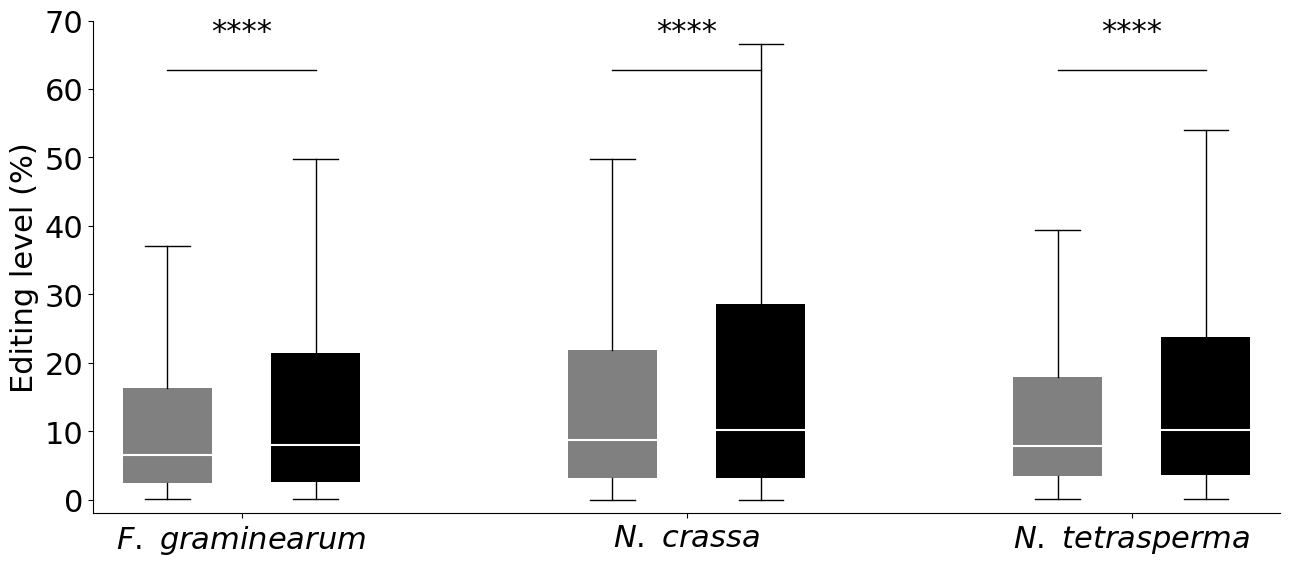

In [18]:
species_dict = {
    'fg': {'syn': fg_s_editingLevel_sex, 'nonsyn': fg_n_editingLevel_sex},
    'nc': {'syn': nc_s_editingLevel_sex, 'nonsyn': nc_n_editingLevel_sex},
    'nt': {'syn': nt_s_editingLevel_sex, 'nonsyn': nt_n_editingLevel_sex}
}

plot_syn_nonsyn_boxplot(species_dict, ylabel="Editing level (%)")